In [1]:
import random

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, DQN, PPO, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecMonitor
from tqdm import tqdm

In [ ]:
# render the agent demo
def render(env_name, model):
    vec_env = make_vec_env(env_name, n_envs=1)
    obs = vec_env.reset()

    for i in range(1000):
        action, _state = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        vec_env.render("human")

def plot_reward(episode_rewards, env_end_idx=None):
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards, label="Episode Reward")
    
    if env_end_idx:
        for x in env_end_idx:
            plt.axvline(x=x, color="red", linestyle="--")

    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Episode Rewards")
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
# env_name = "Hopper-v5"
# log_file = "hopper"
# env = gym.make(env_name)
# env = Monitor(env, filename=log_file)
# model = PPO("MlpPolicy", env=env)
# model.learn(total_timesteps=50000)

In [5]:
from stable_baselines3.common.callbacks import BaseCallback
from tqdm import tqdm

class TqdmProgressCallback(BaseCallback):
    def __init__(self, total_timesteps, verbose=0):
        super().__init__(verbose)
        self.total_timesteps = total_timesteps
        self.progress_bar = None
        self.last_update = 0

    def _on_training_start(self):
        self.progress_bar = tqdm(total=self.total_timesteps, desc="Training Progress", unit="steps")

    def _on_step(self) -> bool:
        delta_n = self.num_timesteps - self.last_update
        self.progress_bar.update(delta_n)
        self.last_update = self.num_timesteps
        return True

    def _on_training_end(self):
        self.progress_bar.close()

In [ ]:
env_name = "Hopper-v5"
log_file = "hopper"
total_timesteps=1000000
progress_callback = TqdmProgressCallback(total_timesteps=total_timesteps)
env = make_vec_env(env_name, n_envs=8)
env = VecMonitor(env, filename=log_file)
model = PPO("MlpPolicy", env=env)
model.learn(total_timesteps=total_timesteps, callback=progress_callback)

/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
Training Progress: 1015808steps [05:12, 3254.03steps/s]                         


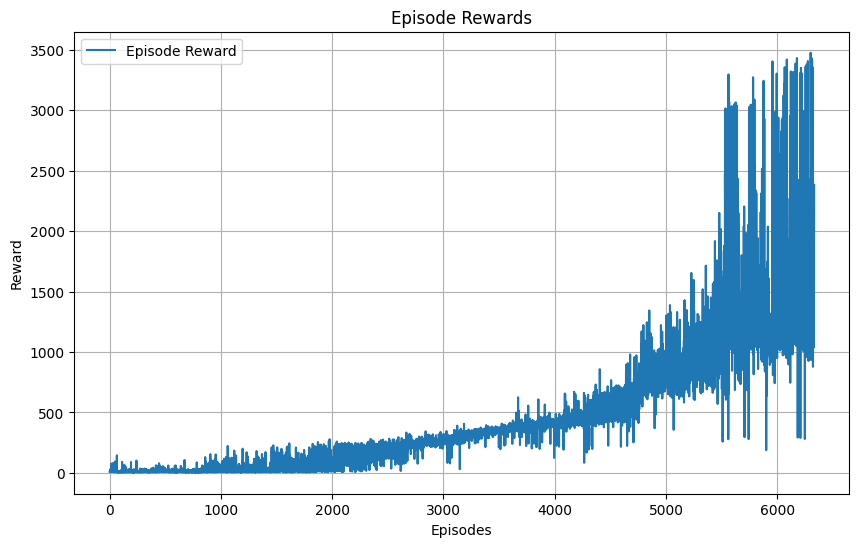

In [10]:
log = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments
plot_reward(log["r"])

In [ ]:
render("Hopper-v5", model)

## Continuous Setup

  0%|          | 0/5 [00:00<?, ?it/s]

gravity -9.81


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 20%|██        | 1/5 [01:35<06:22, 95.57s/it]

gravity -4.643548370920961


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 40%|████      | 2/5 [03:17<04:58, 99.47s/it]

gravity -7.792973189419584


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 60%|██████    | 3/5 [04:57<03:19, 99.70s/it]

gravity -4.1471437089551735


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
 80%|████████  | 4/5 [06:35<01:38, 98.93s/it]

gravity -7.839561531898946


/Users/stevenkao/miniconda3/envs/rl-final/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
100%|██████████| 5/5 [08:14<00:00, 98.87s/it]


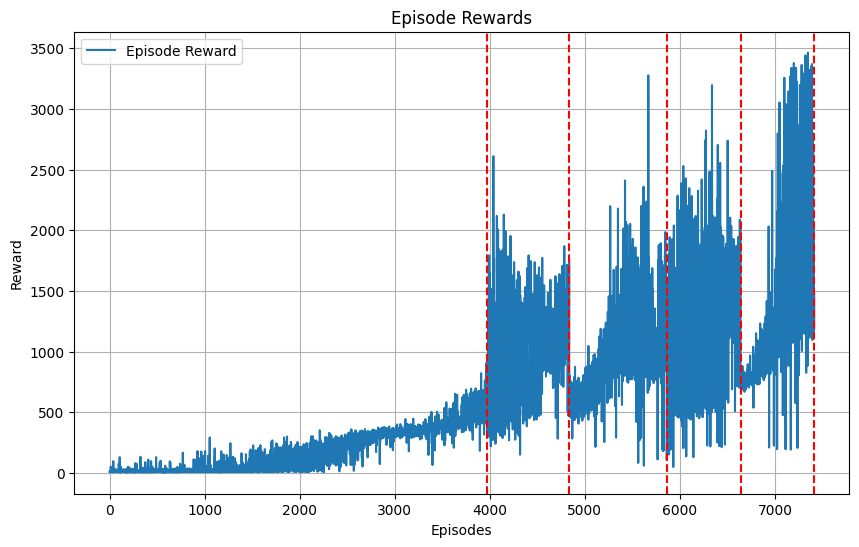

In [ ]:
import torch

def create_env(log_file, gravity):
    env = make_vec_env(
        "Hopper-v5",
        n_envs=8,
    )
    env = VecMonitor(env, filename=log_file)
    for i in range(env.num_envs):
        env.envs[i].unwrapped.model.opt.gravity = [0.0, 0.0, gravity]
    return env


def next_gravity(cur):
    while True:
        x = random.uniform(-4, -10)
        if abs(cur - x) >= 3:
            return x


log_file = "hopper"
cur_gravity = -9.81
env = create_env(log_file, cur_gravity)
model = PPO(
    "MlpPolicy",
    env=env,
    verbose=False,
)

episode_rewards = []
epoch_end_idx = []

for _ in tqdm(range(5)):
    print("gravity", cur_gravity)
    model.learn(total_timesteps=300000)
    log = pd.read_csv(f"{log_file}.monitor.csv", skiprows=1)  # Skip header comments
    episode_rewards.extend(log["r"])
    epoch_end_idx.append(len(episode_rewards))

    env.close()
    cur_gravity = next_gravity(cur_gravity)
    env = create_env(log_file, cur_gravity)
    model.set_env(env)


In [49]:
env = make_vec_env(
    "Hopper-v5",
    n_envs=8,
)
model.set_env(env)
obs = env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render("human")